In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import re
from tqdm import notebook
from re import compile
from utils.regex_fx import remove_single_char, remove_numbers, remove_urls, remove_emojis, remove_extra_spaces, remove_rt, remove_nonalpha, remove_mention, strip_list_noempty
from collections import Counter
import spacy
nlp = spacy.load("en_core_web_sm")
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [175]:
pan_dataset = pd.read_pickle('all_collected_users_en')
true = pan_dataset[pan_dataset['claim_label']=='true']
false = pan_dataset[pan_dataset['claim_label']=='false']

In [225]:
pan_dataset[pan_dataset['source']=='politifact']

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
1275297,politifact,@bobmooreim,true,1,"\n""Only 12% of legal immigrants are selected b...",/bobmooreim/status/1137722294858539008,7:05 AM - 9 Jun 2019,"#DonaldTrump,#ImmigrationReform #Immigration, ..."
1275298,politifact,@statesman,true,1,"\n""Only 12% of legal immigrants are selected b...",/statesman/status/1133416551028338688,9:55 AM - 28 May 2019,"Trump said, “Only 12% of legal immigrants are ..."
1275299,politifact,@penelope7usa,true,1,"\n""Only 12% of legal immigrants are selected b...",/penelope7usa/status/1129248526796578816,9:53 PM - 16 May 2019,Hate to be the bearer of continuous bad news:\...
1275300,politifact,@PolitiFact,false,4,"\n""In America today, women on average are paid...",/PolitiFact/status/1141769683789668352,11:08 AM - 20 Jun 2019,.@KamalaHarris said during a @colbertlateshow ...
1275301,politifact,@tscott1998,false,7,"\n""How to Survive The Coming Ice Age"" was a Ti...",/tscott1998/status/1131631212202741760,11:41 AM - 23 May 2019,"Viral image: ""How to Survive The Coming Ice Ag..."
...,...,...,...,...,...,...,...,...
1756436,politifact,@kklass,true,12877,"\n""We now have the greatest income inequality ...",/kklass/status/909770836235755520,6:27 AM - 18 Sep 2017,Shame GOP doesn't respect providing for the ge...
1756437,politifact,@galactiicactus,true,12877,"\n""We now have the greatest income inequality ...",/galactiicactus/status/882072182171377664,8:02 PM - 3 Jul 2017,income inequality the greatest it has been sin...
1756438,politifact,@seiu1021,true,12877,"\n""We now have the greatest income inequality ...",/seiu1021/status/553260577997725696,10:42 AM - 8 Jan 2015,At a time of the greatest income inequality si...
1756439,politifact,@JohnFugelsang,true,12877,"\n""We now have the greatest income inequality ...",/JohnFugelsang/status/529736078425878528,12:44 PM - 4 Nov 2014,#Imnotvoting b/c we've got the greatest income...


### The amount of fake and false news for each source

In [176]:
true.source.value_counts()

gossipcop     958667
politifact    141210
snopes         54450
emergent        7764
Name: source, dtype: int64

In [177]:
false.source.value_counts()

politifact               339934
snopes                   254580
gossipcop                176307
leadstories-anastasia    132356
emergent                    203
Name: source, dtype: int64

In [178]:
politifact_true = true[true.source=='politifact']
politifact_false = false[false.source=='politifact']
gossipcop_true = true[true.source =='gossipcop']
gossipcop_false = false[false.source =='gossipcop']

In [8]:
len(gossipcop_false.claim_text.unique())

3412

In [9]:
gossipcop_false.sort_values('claim_text').head(1)

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
1086882,gossipcop,@GossipCop,false,19146,Kendall Kylie Jenner Jenner NOT Upset Up...,/GossipCop/status/995423424741888001,3:00 PM - 12 May 2018,"Kendall, Kylie Jenner NOT ""Upset"" Over Caitlyn..."


### Date formatting for PAN dataset
- `%I` hour 12-hour clock as a decimal (no zero padding)
- `:` separation between hour and minute
- `%M` minute as a zero padded decimal
- `%p` AM/PM
- ` - ` space-dash-space pattern betwen time and date 
- `%d` date of the month as a decimal (no zero padding)
- `%b` Month abbreviated
- `%Y` Year with century as decimal

In [181]:
def dfDateTimeFormat(df):
    formatted_dates = []
    for item in df.tweet_date:
        formatted_dates.append(datetime.strptime(item, "%I:%M %p - %d %b %Y"))
    df.tweet_date = formatted_dates
    df.sort_values(['claim_id','tweet_date'], ascending=[True, True], inplace=True)
    return df

In [182]:
gossipcop_false = dfDateTimeFormat(gossipcop_false)
gossipcop_true = dfDateTimeFormat(gossipcop_true)
politifact_false = dfDateTimeFormat(politifact_false)
politifact_true = dfDateTimeFormat(politifact_true)

In [12]:
gossipcop_false.head(2)

,source,user,claim_label,claim_id,claim_text,tweet_id,tweet_date,tweet_Text
966714,gossipcop,@TheLoopAu,false,15967,Did Miley Cyrus and Liam Hemsworth secretly ge...,/TheLoopAu/status/700137152143699968,2016-02-17 17:57:00,"UM, did @MileyCyrus and @LiamHemsworth just se..."
966713,gossipcop,@ReadUnwritten,false,15967,Did Miley Cyrus and Liam Hemsworth secretly ge...,/ReadUnwritten/status/700501642412560384,2016-02-18 18:06:00,"Wait, Did Miley Cyrus And Liam Hemsworth Secre..."


In [183]:
def createDeltaTimeCols(df):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item]['deltaT'] = tweet_groups[item].tweet_date.diff().astype('timedelta64[s]', errors='raise')
        tweet_groups[item].fillna(0, inplace=True)
    return tweet_groups

In [184]:
politifact_false_tweet_groups = createDeltaTimeCols(politifact_false)
politifact_true_tweet_groups = createDeltaTimeCols(politifact_true)
gossipcop_false_tweet_groups = createDeltaTimeCols(gossipcop_false)
gossipcop_true_tweet_groups = createDeltaTimeCols(gossipcop_true)

In [16]:
HOUR_IN_SECONDS = 3600
DAY_IN_SECONDS = 24*HOUR_IN_SECONDS
WEEK_IN_SECONDS = 7*DAY_IN_SECONDS

In [17]:
def calculateVirality(tweet_groups):
    results = {}
    tweets_shared_in_less_than_an_hour = 0
    tweets_shared_in_less_than_a_day = 0
    tweets_shared_in_less_than_a_week = 0
    for item in tweet_groups:
        results[item] = tweet_groups[item]['tweet_date'].to_list()
        for index, timestamp in enumerate(results[item]):
            if index+1 < len(results[item]):
                # calculate difference between first tweet and every other tweet
                difference = results[item][index] - results[item][0]
                # extract times 
                days = difference.days
                seconds = difference.seconds
                hours = seconds//3600
                minutes = (seconds//60)%60
                # took less than an hour
                if days == 0 and hours == 0 and minutes < 60:
                    tweets_shared_in_less_than_an_hour+=1
                # took less than a day
                elif days == 0 and hours < 24 and days == 0:
                    tweets_shared_in_less_than_a_day+=1
                # took less than a week
                elif days < 7:
                    tweets_shared_in_less_than_a_week+=1
    return tweets_shared_in_less_than_an_hour, tweets_shared_in_less_than_a_day, tweets_shared_in_less_than_a_week

In [18]:
pf_less_than_an_hour, pf_less_than_a_day, pf_less_than_a_week = calculateVirality(politifact_false_tweet_groups)
pt_less_than_an_hour, pt_less_than_a_day, pt_less_than_a_week = calculateVirality(politifact_true_tweet_groups)
gf_less_than_an_hour, gf_less_than_a_day, gf_less_than_a_week = calculateVirality(gossipcop_false_tweet_groups)
gt_less_than_an_hour, gt_less_than_a_day, gt_less_than_a_week = calculateVirality(gossipcop_true_tweet_groups)


In [162]:
gt_less_than_a_week

71536

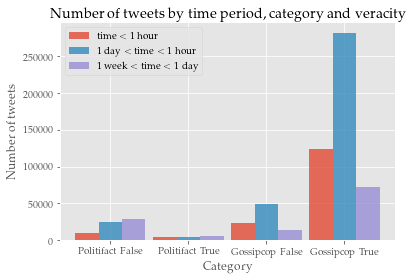

In [164]:
n_groups = 4
hour = (pf_less_than_an_hour, pt_less_than_an_hour, gf_less_than_an_hour, gt_less_than_an_hour)
day = (pf_less_than_a_day, pt_less_than_a_day, gf_less_than_a_day, gt_less_than_a_day)
week = (pf_less_than_a_week, pt_less_than_a_week, gf_less_than_a_week, gt_less_than_a_week)

# create plot
fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, hour, bar_width,
alpha=opacity,
# color='b',
label=r'time $<$ 1 hour ')

rects2 = plt.bar(index + bar_width, day, bar_width,
alpha=opacity,
# color='g',
label=r'1 day $<$ time $<$ 1 hour')

rects3 = plt.bar(index + bar_width + bar_width, week, bar_width,
alpha=opacity,
# color='r',
label=r'1 week  $<$ time  $<$ 1 day')

plt.xlabel('Category')
plt.ylabel('Number of tweets')
plt.title('Number of tweets by time period, category and veracity')
plt.xticks(index + bar_width, ('Politifact False', 'Politifact True', 'Gossipcop False', 'Gossipcop True'))
plt.legend()

# plt.tight_layout()
plt.show()

In [50]:
def calculateBuckets(tweet_groups):
    results = {}
    tweet_buckets = {}
    tweets_shared_in_less_than_an_hour = 0
    tweets_shared_in_less_than_a_day = 0
    tweets_shared_in_less_than_a_week = 0
    for item in tweet_groups:
        hour_count = 0
        quarter_count = 0
        results[item] = tweet_groups[item]['tweet_date'].to_list()
        # article level
        for index, timestamp in enumerate(results[item]):
            if index+1 < len(results[item]):
                # calculate difference between first tweet and every other tweet
                difference = results[item][index] - results[item][0]
                
                # extract times 
                days = difference.days
                seconds = difference.seconds
                hours = seconds//3600
                minutes = (seconds//60)%60
                

                total_minutes = hours*60 + days*24*60 + minutes
                # took less than an hour
                # if days == 0 and hours < hour_count and minutes < 60:
                if total_minutes < quarter_count*5:
                    try:
                        tweet_buckets[quarter_count] += 1
                    except KeyError:
                        tweet_buckets[quarter_count] = 1
            quarter_count+=1
            # hour_count+=1
              
    return tweet_buckets

In [51]:
gossipcop_true_buckets = calculateBuckets(gossipcop_true_tweet_groups)
gossipcop_false_buckets = calculateBuckets(gossipcop_false_tweet_groups)
politifact_true_buckets = calculateBuckets(politifact_true_tweet_groups)
politifact_false_buckets = calculateBuckets(politifact_false_tweet_groups)


In [165]:
# politifact_true_buckets

In [54]:
def createHourBucket(df):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item]['hours'] = tweet_groups[item]['tweet_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()\
            .cumsum().div(60*60).astype(int)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [169]:
def createCumulativeIntervalBucket(df, interval):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item][f'{interval}_minutes_cumulative'] = tweet_groups[item]['tweet_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds()\
            .cumsum().div(60*interval).astype(int)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [187]:
def createIntervalBucket(df, interval):
    tweet_groups = {}
    for name, group in df.groupby('claim_id'):
        tweet_groups['group_'+str(name)] = group
    for item in tweet_groups:
        tweet_groups[item][f'{interval}_minutes_delta'] = tweet_groups[item]['tweet_date'].diff().astype('timedelta64[m]', errors='raise')
        tweet_groups[item].fillna(0, inplace=True)
        # tweet_groups[item].set_index('tweet_date').resample('30min').count()
    return tweet_groups

In [188]:
# politifact_true_hours = createHourBucket(politifact_true)
politifact_true_minutes = createIntervalBucket(politifact_true, 1)
politifact_false_minutes = createIntervalBucket(politifact_false, 1)
gossipcop_true_minutes = createIntervalBucket(gossipcop_true, 1)
gossipcop_false_minutes = createIntervalBucket(gossipcop_false, 1)


In [189]:
politifact_true_hours_cumulative = createCumulativeIntervalBucket(politifact_true, 60)
politifact_true_hour_delta = createIntervalBucket(politifact_true, 60)

In [194]:
politifact_true_hour_delta['group_15'].iloc[:,-1:].sum()

60_minutes_delta    1682835.0
dtype: float64

In [211]:
def calculateArticleVirality(df):
    nr_tweets_for_article = len(df)
    total_time = df.iloc[:,-1:].sum()
    article_virality = total_time/nr_tweets_for_article
    return article_virality

### We can pass in a single article and calculate the virality as the time it took for the `n` tweets to occur

In [213]:
calculateArticleVirality(politifact_true_hour_delta['group_15'])

60_minutes_delta    20775.740741
dtype: float64

In [212]:
def calculateDfVirality(df):
    articles_virality = 0
    for item in df:
        single_article_virality = calculateArticleVirality(df[item])
        # print(item,':', single_article_virality)
        articles_virality+=single_article_virality
    return articles_virality/len(df)


### We can pass the dataframe contianing and calculate the virality as the time it took for the `n` tweets to occur

In [209]:
pt_article_virality = calculateDfVirality(politifact_true_tweet_groups)
pf_article_virality = calculateDfVirality(politifact_false_tweet_groups)
gt_article_virality = calculateDfVirality(gossipcop_true_tweet_groups)
gf_article_virality = calculateDfVirality(gossipcop_false_tweet_groups)

In [210]:
print(int(pt_article_virality))
print(int(pf_article_virality))
print(int(gt_article_virality))
print(int(gf_article_virality))

3930828
2994459
453707
476923


In [115]:
# hours should be interval so instead of minutes
def createBinnedDict(df):
    interval_bucket = {}
    for name in df:
        interval_count = 0
        for index, item in df[name].iterrows():
            if hour_count not in interval_bucket:
                interval_bucket[interval_count] = 0
            if item['hours'] not in interval_bucket:
                interval_bucket[item['hours']] = 1
            else:
                interval_bucket[item['hours']] += 1
            interval_count+=1
    return interval_bucket

In [116]:
pt_hour_bucket = createBinnedDict(politifact_true_hours)

In [135]:
pt_minute_bucket = createBinnedDict(politifact_true_minutes)
pf_minute_bucket = createBinnedDict(politifact_false_minutes)
gt_minute_bucket = createBinnedDict(gossipcop_true_minutes)
gf_minute_bucket = createBinnedDict(gossipcop_false_minutes)

In [117]:
pt_sorted_hour_bucket = dict(sorted(pt_hour_bucket.items()))

In [136]:
pt_sorted_minute_bucket = dict(sorted(pt_minute_bucket.items()))
pf_sorted_minute_bucket = dict(sorted(pf_minute_bucket.items()))
gt_sorted_minute_bucket = dict(sorted(gt_minute_bucket.items()))
gf_sorted_minute_bucket = dict(sorted(gf_minute_bucket.items()))

In [146]:
# pt_lists = sorted(politifact_true_buckets.items()) # sorted by key, return a list of tuples

gt_lists = sorted(gt_sorted_minute_bucket.items())[1:] # sorted by key, return a list of tuples
gf_lists = sorted(gf_sorted_minute_bucket.items())[1:] # sorted by key, return a list of tuples
pt_lists = sorted(pt_sorted_minute_bucket.items())[1:] # sorted by key, return a list of tuples
pf_lists = sorted(pf_sorted_minute_bucket.items())[1:] # sorted by key, return a list of tuples

x_gt, y_gt = zip(*gt_lists) # unpack a list of pairs into two tuples
x_gf, y_gf = zip(*gf_lists) # unpack a list of pairs into two tuples
x_pt, y_pt = zip(*pt_lists) # unpack a list of pairs into two tuples
x_pf, y_pf = zip(*pf_lists) # unpack a list of pairs into two tuples

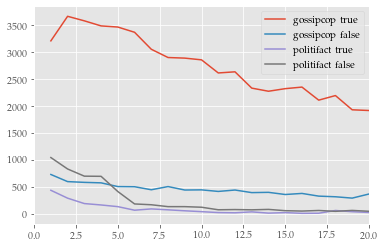

In [149]:

# create plot
fig, ax = plt.subplots()

line1 = ax.plot(x_gt, y_gt, label='gossipcop true')
line2 = ax.plot(x_gf, y_gf, label='gossipcop false')
line3 = ax.plot(x_pt, y_pt, label='politifact true')
line4 = ax.plot(x_pf, y_pf, label='politifact false')

plt.legend()
plt.xlim(0,20)
# plt.ylim(-20,2000)
plt.show()

In [149]:
# pf_results = {}
# tweets_shared_in_less_than_an_hour = 0
# tweets_shared_in_less_than_a_day = 0
# tweets_shared_in_less_than_a_week = 0
# for item in politifact_false_tweet_groups:
#     pf_results[item] = politifact_false_tweet_groups[item]['tweet_date'].to_list()
#     for index, timestamp in enumerate(pf_results[item]):
#         if index+1 < len(pf_results[item]):
#             # calculate difference between first tweet and every other tweet
#             difference = pf_results[item][index] - pf_results[item][0]
#             # extract times 
#             days = difference.days
#             seconds = difference.seconds
#             hours = seconds//3600
#             minutes = (seconds//60)%60
#             # took less than an hour
#             if days == 0 and hours == 0 and minutes < 60:
#                 tweets_shared_in_less_than_an_hour+=1
#             # took less than a day
#             if days == 0 and hours < 24:
#                 tweets_shared_in_less_than_a_day+=1
#             # took less than a week
#             if days < 7:
#                 tweets_shared_in_less_than_a_week+=1

In [150]:
tweets_shared_in_less_than_an_hour

9550

In [16]:
# true_text_list = true.claim_text.unique()
# false_text_list = false.claim_text.unique()
# 
true_text_list = politifact_true.claim_text.unique()
false_text_list = politifact_false.claim_text.unique()


In [ ]:
Extra regex

In [ ]:
pf_results = {}
for item in politifact_false_tweet_groups:
    pf_results[item] = politifact_false_tweet_groups[item]['tweet_date'].to_list()
    for index, timestamp in enumerate(pf_results[item]):
        if index < len(pf_results[item])-1:
            difference = pf_results[item][index+1] - pf_results[item][index]
            if difference.total_seconds() < HOUR_IN_SECONDS:
                print(difference)
    

In [17]:
def process_text(text):
    res = remove_numbers(text)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_urls(res)
    res = remove_single_char(res)
    return res

In [25]:

processed_true_text = []

for index, item in enumerate(notebook.tqdm(true_text_list)):
    processed_true_text.append(process_text(item))


processed_false_text = []

for index, item in enumerate(notebook.tqdm(false_text_list)):
    processed_false_text.append(process_text(item))

        

  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/2745 [00:00<?, ?it/s]

In [26]:
processed_texts_false = [text for text in notebook.tqdm(nlp.pipe(false_text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(false_text_list))]

  0%|          | 0/2745 [00:00<?, ?it/s]

In [40]:
processed_texts_true = [text for text in notebook.tqdm(nlp.pipe(true_text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(true_text_list))]

  0%|          | 0/1468 [00:00<?, ?it/s]

In [41]:
tokenized_texts_false = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts_false)]

  0%|          | 0/2745 [00:00<?, ?it/s]

In [42]:
tokenized_texts_true = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts_true)]

  0%|          | 0/1468 [00:00<?, ?it/s]

In [43]:
from gensim.corpora import Dictionary

MIN_DF = 5 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary_false = Dictionary(tokenized_texts_false) # get the vocabulary
dictionary_false.filter_extremes(no_below=MIN_DF, no_above=MAX_DF)
corpus_false = [dictionary_false.doc2bow(text) for text in notebook.tqdm(tokenized_texts_false)]

  0%|          | 0/2745 [00:00<?, ?it/s]

In [44]:

MIN_DF = 5 # minium document frequency
MAX_DF = 0.5 # maximum document frequency

dictionary_true = Dictionary(tokenized_texts_true) # get the vocabulary
dictionary_true.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
corpus_true = [dictionary_true.doc2bow(text) for text in notebook.tqdm(tokenized_texts_true)]

  0%|          | 0/1468 [00:00<?, ?it/s]

In [45]:
N_TOPICS = 5
N_ITERATIONS = 1000

lda_true = LdaMulticore(
                corpus=corpus_true,
                id2word=dictionary_true,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)
                
for topic in range(N_TOPICS):
    words = lda_true.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: job percent year Texas $ say state new time cut
Topic 1: say Trump people Donald vote percent high million $ support
Topic 2: say year 
 

 state $ percent time million country America
Topic 3: say year U.S. pay federal world country taxis   Americans
Topic 4: percent $ year rate tax million country 
 

 state people


In [46]:
for topic in range(N_TOPICS):
    words = lda_true.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: job percent year Texas $ say state new time cut
Topic 1: say Trump people Donald vote percent high million $ support
Topic 2: say year 
 

 state $ percent time million country America
Topic 3: say year U.S. pay federal world country taxis   Americans
Topic 4: percent $ year rate tax million country 
 

 state people


In [47]:
from gensim.models import LdaMulticore

PATH_TO_MALLET = 'mallet-2.0.8/bin/mallet'
N_TOPICS = 30
N_ITERATIONS = 1000

lda_false = LdaMulticore(
                corpus=corpus_false,
                id2word=dictionary_false,
                num_topics=N_TOPICS,
                iterations=N_ITERATIONS)

In [48]:
from gensim.models.coherencemodel import CoherenceModel

In [49]:
dictionary = Dictionary(tokenized_texts_false) # get the vocabulary
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_false]
model = LdaMulticore(corpus=corpus, num_topics=5, id2word=dictionary, alpha = 0.1, iterations = 400)
coherencemodel = CoherenceModel(model=model, texts=tokenized_texts_false, dictionary=dictionary, coherence='c_v', topn=3)

In [6]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [59]:
def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    # corpus = [remove_special_names(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]

    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus,  disable=["ner", "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
    # tokenized_texts = make_n_grams(tokenized_texts)

    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

In [60]:
fake = pre_processer_fake(false_text_list)

  0%|          | 0/2745 [00:00<?, ?it/s]

In [61]:
counts_fake, common_fake, flat_fake, tokenized_texts_fake = fake

In [62]:
common_fake[:20]

[('say', 684),
 ('year', 202),
 ('nt', 201),
 ('state', 200),
 ('obama', 199),
 ('trump', 188),
 ('president', 178),
 ('people', 139),
 ('tax', 137),
 ('percent', 136),
 ('clinton', 130),
 ('million', 118),
 ('vote', 111),
 ('go', 97),
 ('american', 95),
 ('new', 95),
 ('country', 95),
 ('hillary', 93),
 ('health', 92),
 ('pay', 91)]

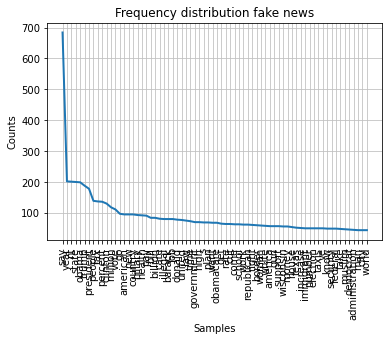

<AxesSubplot:title={'center':'Frequency distribution fake news'}, xlabel='Samples', ylabel='Counts'>

In [63]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_fake)
fdist_filtered.plot(70,title='Frequency distribution fake news')

In [54]:
def text_preprocessing(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    # corpus = [remove_special_names(text) for text in corpus]

    corpus = strip_list_noempty(corpus)

    processed_texts = [text for text in nlp.pipe(corpus,  disable=["ner", "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]
    # tokenized_texts = make_n_grams(tokenized_texts)
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flat_fake, tokenized_texts

In [55]:
real = text_preprocessing(true_text_list)

  0%|          | 0/1468 [00:00<?, ?it/s]

In [56]:
counts_real, common_real, flat_real, tokenized_texts_real = real

In [57]:
common_real[:20]

[('say', 215),
 ('year', 183),
 ('percent', 182),
 ('state', 176),
 ('american', 93),
 ('million', 93),
 ('people', 86),
 ('rate', 82),
 ('trump', 81),
 ('job', 79),
 ('tax', 76),
 ('country', 74),
 ('high', 71),
 ('vote', 71),
 ('time', 71),
 ('pay', 68),
 ('president', 68),
 ('obama', 56),
 ('billion', 54),
 ('texas', 51)]

In [58]:
from gensim.models import LdaMulticore

def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.01, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [64]:
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=1, step=1, limit= 40, topn=5)


In [65]:
coherence_values

[0.04194414277374631,
 0.1741988946760286,
 0.2581198754240313,
 0.17443867888532397,
 0.2541719610576217,
 0.22402577790551556,
 0.2765607481409097,
 0.2988220797552694,
 0.2818430761828567,
 0.3058160371989837,
 0.32158226074440355,
 0.345310474448237,
 0.31365346715282294,
 0.30562627925886193,
 0.3691568664011894,
 0.3620641462280916,
 0.39522878162478264,
 0.35580273212279595,
 0.3716378800677325,
 0.34641160232521606,
 0.379859201025418,
 0.3754862473823561,
 0.36588103676322264,
 0.3917363329076456,
 0.3620818202018071,
 0.35084351019732235,
 0.37255740333603304,
 0.3555025889239515,
 0.3861149520249198,
 0.38419615533493057,
 0.37606422084522445,
 0.36389565043375,
 0.3865796155653976,
 0.3906310750004011,
 0.38349588037582855,
 0.34986749447711196,
 0.38691455382429085,
 0.3774641982767532,
 0.3752120528946009]

At this point the coherence scores are low, meaning there's not much confidence in the topics modelled. What if we merge the politifact dataset

In [377]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(text)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    return res

In [378]:
pf = pd.read_csv('processed-data/tweet_times/politifact_fake_tweet_times.csv')

In [379]:
cleaned_pf_text = []
for item in pf.text:
    cleaned_pf_text.append(cleanup(item))
pf.text = cleaned_pf_text

In [381]:
# cleaned_nd_text = []
# for item in new_dataset.claim_text:
#     cleaned_nd_text.append(cleanup(item))

In [219]:
# new_dataset.claim_text = cleaned_nd_text

In [220]:
# len(new_dataset.claim_text.unique())

25085

In [383]:
pf = pf.drop_duplicates(subset=['text'], keep='first')
pf = pf.sort_values('text')

In [384]:
pf.reset_index(drop=True, inplace=True)
for index, item in pf.iterrows():
    if index < len(pf)-1:
        if similar(pf.loc[index,'text'], pf.loc[index+1,'text']) > 0.90:
            pf.drop(index, inplace = True)


In [386]:
pf = pf[pf.text.notnull()]
pf = pf[pf.text != ""]
pf = pf[pf.text.str.len() > 15]

In [387]:
pf

,Unnamed: 0,created_at,text,author_id,id,news_id,withheld
2,38867,2016-06-21T14:22:52.000Z,000pound great white shark captured in great ...,3301735767,7.452607e+17,politifact14309,NaN
3,38940,2017-07-01T17:31:55.000Z,000pound great white shark captured in great ...,878694851801436161,8.812037e+17,politifact14309,NaN
4,38944,2017-07-02T00:46:24.000Z,000pound great white shark captured in great ...,72577718,8.813131e+17,politifact14309,NaN
5,38905,2017-06-22T22:49:41.000Z,000pound great white shark captured in great ...,110370047,8.780222e+17,politifact14309,NaN
6,38911,2017-06-26T20:53:35.000Z,000pound great white shark captured in great ...,90688327,8.794425e+17,politifact14309,NaN
...,...,...,...,...,...,...,...
37312,61015,2017-01-28T07:42:18.000Z,zuckerberg takes on trump on immigration calls...,790883836276060161,8.252476e+17,politifact15573,NaN
37313,16250,2018-04-11T14:13:38.000Z,zuckerberg testifying before the us house of r...,630417033,9.840720e+17,politifact14548,NaN
37314,20730,2018-07-17T11:39:18.000Z,zulumkhathini no problems,966951978172641280,1.019185e+18,politifact14548,NaN
37316,25643,2018-07-20T15:51:21.000Z,zz tops billy gibbons releases gritty muddy wa...,531242779,1.020335e+18,politifact14548,NaN


In [267]:
cleaned_pf_text = []
for item in pf.text:
    cleaned_pf_text.append(cleanup(item))
pf.text = cleaned_pf_text

,created_at,text,author_id,id,news_id
0,2017-10-03T15:48:10.000Z,"oh, gays for trump. calling on gays for trump!...",42013288,9.152421e+17,politifact15371
1,2017-10-03T16:19:10.000Z,fyi trump admin voted for death penalty for ga...,250756569,9.152499e+17,politifact15371
2,2017-10-03T21:28:30.000Z,breaking: trump votes for death penalty for be...,143618120,9.153277e+17,politifact15371
3,2017-10-03T21:28:51.000Z,"watch out, this is trump's america. us votes a...",26292109,9.153278e+17,politifact15371
4,2017-10-03T21:32:06.000Z,trump administration votes against un resoluti...,716371621380890624,9.153286e+17,politifact15371
...,...,...,...,...,...
35331,2017-03-11T19:28:08.000Z,chinese lunar rover finds no evidence of ameri...,2463640190,8.406455e+17,politifact14718
35332,2017-03-12T09:33:50.000Z,chinese lunar rover finds no evidence of ameri...,421173069,8.408584e+17,politifact14718
35333,2017-03-14T10:50:12.000Z,laugh - chinese lunar rover finds no evidence ...,228008431,8.416024e+17,politifact14718
35334,2017-03-31T07:30:11.000Z,schischowwn1 . . chinese lunar rover finds no...,2320446493,8.477126e+17,politifact14718


In [388]:
pf.to_csv('processed-data/tweets_cleaned/pf.csv')

In [164]:
combined_fake = np.append(pf_unique_text.ravel(),false.claim_text.unique().ravel())

In [139]:
false.claim_text

133        Robot security guards are patrolling a Microso...
134        Robot security guards are patrolling a Microso...
151        Amazon will open its first physical store in N...
152        Comcast is telling customers Tor is illegal to...
4740       Saudi Arabia's national airline will introduce...
                                 ...                        
2065466            Did a Cursed Mummy Sink with the Titanic?
2065467            Did a Cursed Mummy Sink with the Titanic?
2065468    Did the Chevrolet Nova Fail to Sell in Spanish...
2065469    Does a Ghost Boy Appear in ‘Three Men and a Ba...
2065470    Does a Ghost Boy Appear in ‘Three Men and a Ba...
Name: claim_text, Length: 903380, dtype: object